In [4]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='kbZR7cE4Ph5rR6zpat2QxIaiDSYCmOScBVCPMQ2DXBip',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/identity/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.direct.us-south.cloud-object-storage.appdomain.cloud')

bucket = 'networkintrusiondetectionproject-donotdelete-pr-sajt1rthpbknmd'
object_key = 'Train_data.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

train_df = pd.read_csv(body)
train_df.head(10)
!pip install pandas numpy scikit-learn matplotlib seaborn

In [7]:
print("Train columns:\n", train_df.columns.tolist())

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='kbZR7cE4Ph5rR6zpat2QxIaiDSYCmOScBVCPMQ2DXBip',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/identity/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.direct.us-south.cloud-object-storage.appdomain.cloud')

bucket = 'networkintrusiondetectionproject-donotdelete-pr-sajt1rthpbknmd'
object_key = 'Test_data.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

test_df = pd.read_csv(body)
test_df.head(10)
print("Test columns:\n", test_df.columns.tolist())

Train columns:
 ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'class']
Test columns:
 ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creation

In [11]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

df = train_df.copy()

# Encode the target column
le_target = LabelEncoder()
df['label'] = le_target.fit_transform(df['class'])

# Encode categorical columns
categorical_cols = ['protocol_type', 'service', 'flag']
le_dict = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le  # Save encoders if needed for test data later

# Drop target column from features
X = df.drop(['class', 'label'], axis=1)
y = df['label']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize numeric features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9964276263561789
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3516
           1       1.00      1.00      1.00      4042

    accuracy                           1.00      7558
   macro avg       1.00      1.00      1.00      7558
weighted avg       1.00      1.00      1.00      7558



In [13]:
# Pick a sample from the test set
sample_index = 0  # Change this index to test other samples
sample = X_test.iloc[sample_index]

# Reshape and scale it
sample_scaled = scaler.transform([sample])

# Predict
predicted_class_num = model.predict(sample_scaled)[0]
predicted_label = le_target.inverse_transform([predicted_class_num])[0]
actual_label = le_target.inverse_transform([y_test.iloc[sample_index]])[0]

print("Actual Label   :", actual_label)
print("Predicted Label:", predicted_label)


Actual Label   : anomaly
Predicted Label: anomaly


/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [14]:
for i in range(10):
    sample = X_test.iloc[i]
    actual_label = le_target.inverse_transform([y_test.iloc[i]])[0]
    predicted_class = model.predict([scaler.transform([sample])[0]])[0]
    predicted_label = le_target.inverse_transform([predicted_class])[0]

    print(f"Sample {i+1}")
    print("  Actual   :", actual_label)
    print("  Predicted:", predicted_label)
    print("-" * 30)


Sample 1
  Actual   : anomaly
  Predicted: anomaly
------------------------------
Sample 2
  Actual   : normal
  Predicted: normal
------------------------------
Sample 3
  Actual   : anomaly
  Predicted: anomaly
------------------------------
Sample 4
  Actual   : normal
  Predicted: normal
------------------------------
Sample 5
  Actual   : anomaly
  Predicted: anomaly
------------------------------
Sample 6
  Actual   : normal
  Predicted: normal
------------------------------
Sample 7
  Actual   : normal
  Predicted: normal
------------------------------
Sample 8
  Actual   : normal
  Predicted: normal
------------------------------
Sample 9
  Actual   : normal
  Predicted: normal
------------------------------
Sample 10
  Actual   : anomaly
  Predicted: anomaly
------------------------------


/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/conda/envs/Python-RT24.1/

In [15]:
# Predict for full test set
y_pred = model.predict(X_test_scaled)
y_pred_labels = le_target.inverse_transform(y_pred)
y_actual_labels = le_target.inverse_transform(y_test)

# Create a DataFrame of predictions
results_df = X_test.copy()
results_df['Actual'] = y_actual_labels
results_df['Predicted'] = y_pred_labels

# Display mismatches
incorrect = results_df[results_df['Actual'] != results_df['Predicted']]
print("Incorrect predictions:")
print(incorrect.head())


Incorrect predictions:
       duration  protocol_type  service  flag  src_bytes  dst_bytes  land  \
9807          0              0       13     9          8          0     0   
3592          0              0       13     9         20          0     0   
23962         0              1       19     9        245          0     0   
18264         0              1       19     9        172          0     0   
21445       299              1       57     9        112        847     0   

       wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
9807                0       0    0  ...                    0.01   
3592                0       0    0  ...                    0.02   
23962               0       0    0  ...                    1.00   
18264               0       0    0  ...                    1.00   
21445               0       0    0  ...                    0.19   

       dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
9807                     0.03                    

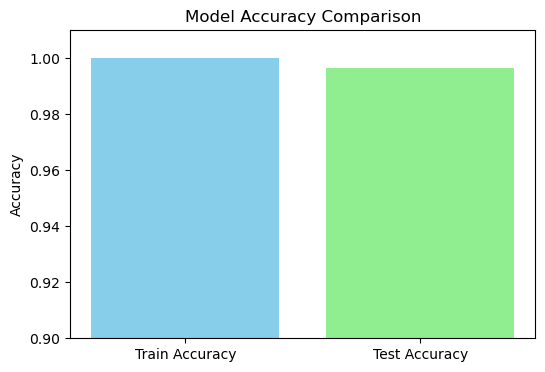

In [16]:
# Get predictions on train set
y_train_pred = model.predict(X_train_scaled)

from sklearn.metrics import accuracy_score
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_pred)

import matplotlib.pyplot as plt

# Bar graph of accuracies
plt.figure(figsize=(6,4))
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_acc, test_acc], color=['skyblue', 'lightgreen'])
plt.ylim(0.9, 1.01)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()


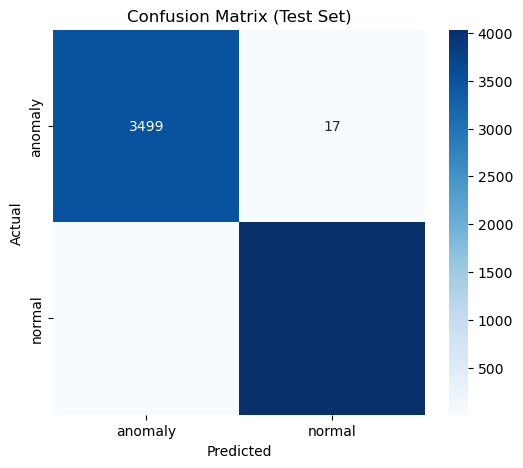

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
plt.show()


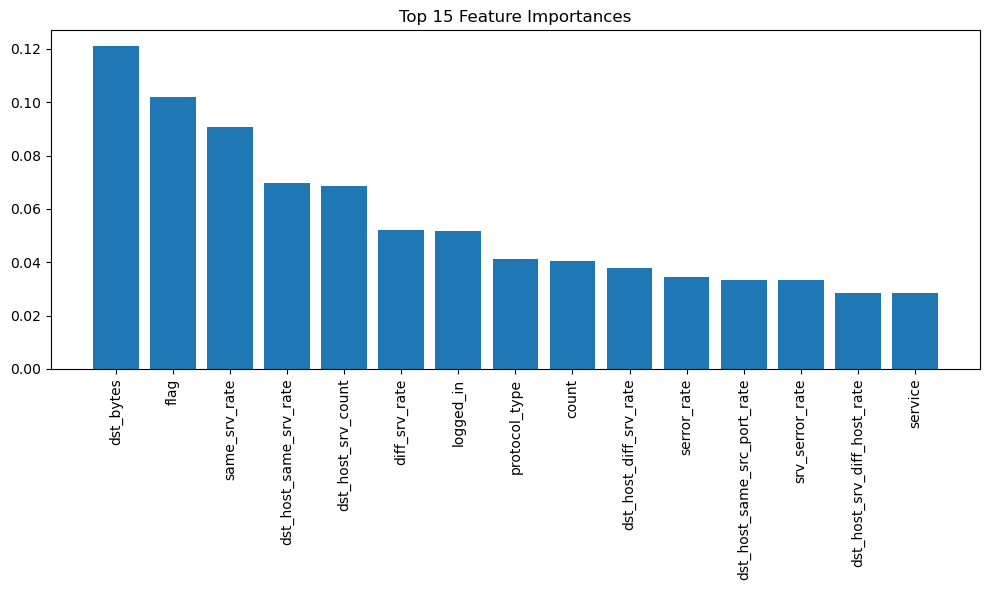

In [18]:
import numpy as np

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Plot the top 15 important features
plt.figure(figsize=(10,6))
plt.title("Top 15 Feature Importances")
plt.bar(range(15), importances[indices[:15]], align="center")
plt.xticks(range(15), [feature_names[i] for i in indices[:15]], rotation=90)
plt.tight_layout()
plt.show()


In [10]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='MotgyaDY8upebp5MMPuaY2Vd_k79OpNnpBqjJ1xNKtvm',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/identity/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.direct.au-syd.cloud-object-storage.appdomain.cloud')

bucket = 'ibmnids-donotdelete-pr-icds5a0jj3d64m'
object_key = 'nids_project.pkl'

# load data of type "application/octet-stream" into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/

streaming_body_1 = cos_client.get_object(Bucket=bucket, Key=object_key)['Body']


In [11]:
!pip install ibm-watson-machine-learning


In [17]:
joblib.dump(model, 'nids_project.pkl')


['nids_project.pkl']

In [23]:
import zipfile

# Create a zip archive
with zipfile.ZipFile("nids_model.zip", "w") as zipf:
    zipf.write("nids_project.pkl")


In [24]:
import os
print(os.listdir())


['nids_model_bundle.zip', 'scaler.pkl', 'target_encoder.pkl', 'nids_model.pkl', 'nids_model.zip', 'nids_project.pkl']
